# UNET numerical example

In [ ]:
%load_ext autoreload
%autoreload 2
%cd /code

In [2]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
assert tf.test.is_gpu_available()

In [24]:
from pathlib import Path

from matplotlib import pyplot as plt

import numpy as np

from tensorflow.keras import Sequential, callbacks, layers, models

from notebooks.unet import model
from notebooks.nuclei_data import Dataset

In [5]:
train = Dataset(batch_size=10, directory=Path("/code/data/nuclei/train"), with_mask=True)
test = Dataset(batch_size=5, directory=Path("/code/data/nuclei/test"), with_mask=False)

In [6]:
model.fit(
    train,
    epochs=10,
)

Train on 670 samples
Epoch 1/10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
670/670 [==============================] - 16s 24ms/sample - loss: 0.3801 - mean_io_u: 0.4548
Epoch 2/10
670/670 [==============================] - 10s 15ms/sample - loss: 0.2248 - mean_io_u: 0.5183
Epoch 3/10
670/670 [==============================] - 10s 15ms/sample - loss: 0.1646 - mean_io_u: 0.5342
Epoch 4/10
670/670 [==============================] - 10s 15ms/sample - loss: 0.1285 - mean_io_u: 0.5548
Epoch 5/10
670/670 [==============================] - 10s 15ms/sample - loss: 0.1076 - mean_io_u: 0.5726
Epoch 6/10
670/670 [==============================] - 10s 15ms/sample - loss: 0.1058 - mean_io_u: 0.5636
Epoch 7/10
670/670 [==============================] - 10s 15ms/sample - loss: 0.0935 - mean_io_u: 0.5682
Epoch 8/10
670/670 [==============================] - 10s 15ms/sample - loss: 0.0864 - mean_io_u: 0.5692
Epoch 9/10
670/670 [=========================

In [7]:
prediction = model.predict(test)

Showing plot


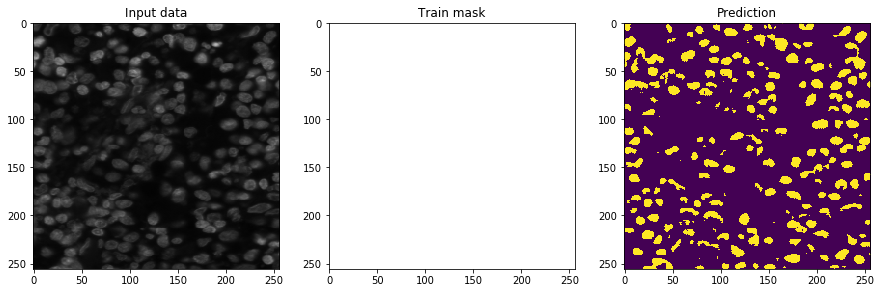

Showing plot


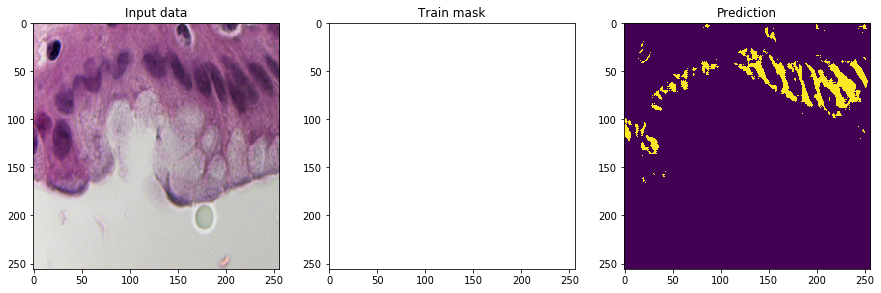

Showing plot


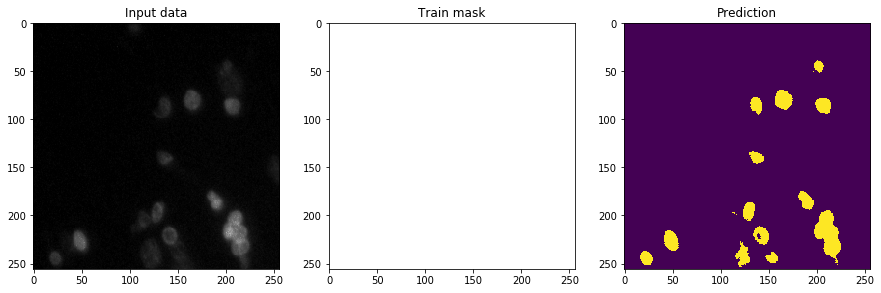

In [8]:
for index in range(0,3):
    test.display(index=index, prediction=prediction[index])

In [9]:
train_prediction = model.predict(train)

Showing plot


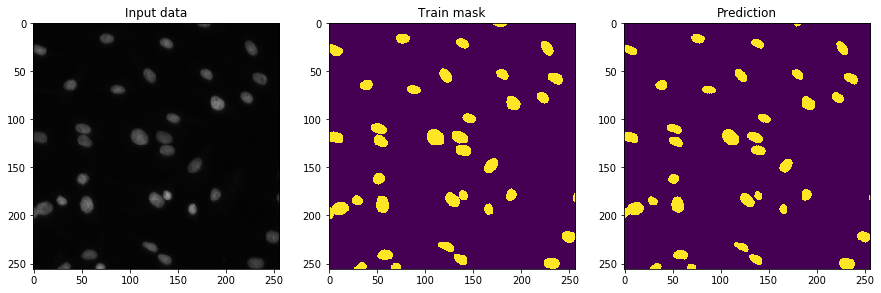

Showing plot


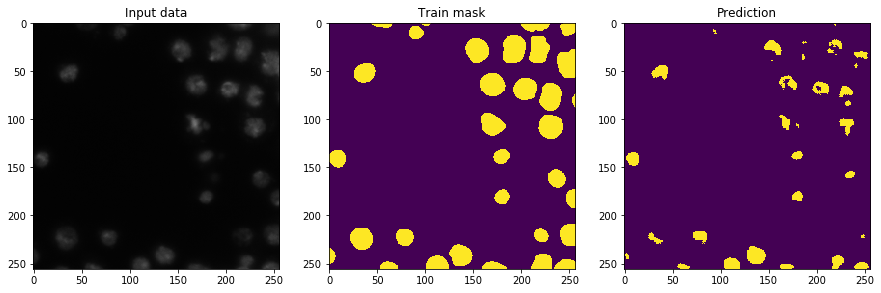

Showing plot


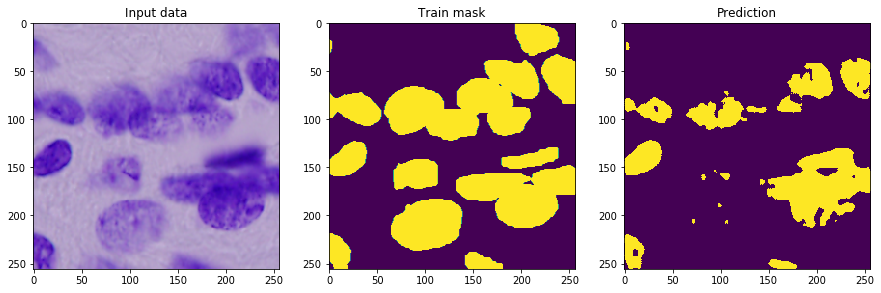

In [10]:
for index in range(0, 3):
    train.display(index=index, prediction=train_prediction[index])

In [45]:
import skimage

test_directory = Path("/code/data/nuclei/stage2_test")
predictions = {}

for subdir in test_directory.iterdir():
    image_id = subdir.name
    image_path = subdir / "images" / (image_id + ".png")
    assert image_path.exists()
    
    raw_image = tf.io.read_file(str(image_path))
    image_tensor = tf.image.decode_png(raw_image, channels=3)
    image_tensor /= 255
    original_shape = tuple(image_tensor.shape)
    image_tensor = tf.image.resize(image_tensor, size=(256, 256))
    image_tensor = tf.expand_dims(image_tensor, 0)
    
    predictions[image_id] = {
        'image_id': image_id,
        'image': np.squeeze(image_tensor.numpy()),
        'original_shape': original_shape,
    }

In [64]:
for image_id, result in predictions.items():    
    predictions[image_id]['prediction'] = np.squeeze(
        model.predict(np.expand_dims(result['image'], 0))
    )

In [65]:
for image_id, result in predictions.items():
    prediction = result['prediction']
    upscaled_prediction = skimage.transform.resize(
        result['prediction'],
        result['original_shape'][:2],
        mode='constant',
        preserve_range=True,
    )
    result['upscaled_prediction'] = upscaled_prediction

(512, 512, 3)


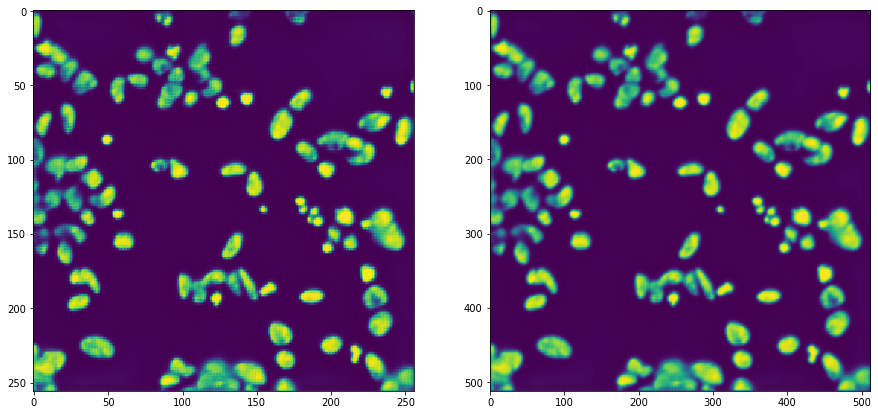

In [68]:
example = list(predictions.values())[261]
print(example['original_shape'])
plt.figure(figsize=(15, 15))
plt.subplot(121)
plt.imshow(np.squeeze(example['prediction']))
plt.subplot(122)
plt.imshow(np.squeeze(example['upscaled_prediction']))
plt.show()

In [70]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
from skimage.morphology import label


def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths


def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)